In [225]:
import pandas as pd 
pd.set_option("display.max_columns", None)
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from lifetimes import BetaGeoFitter

## RFM客戶分群
透過此一方法了解在一段時間內的客戶貢獻度。

**三個字母分別表示：**

- <font color="red">Recency(R)</font>:表示最後一次購買的時間，現在距離最後一次購買的天數。（表示客戶活著的時間）
- <font color="red">Seniority(S)</font>:表示觀測資料節點減掉客戶第一次購買時間。（計算客戶的資歷）
- <font color="red">Frequency(F)</font>:客戶購買的頻率，表示在一定的區間內購買的總次數。（表示重購次數）
- <font color="red">Monetary(M)</font>:客戶的採購總金額加總，表示客戶的總貢獻度。

每個變數都各自由2個項目組成，所以總共可以有**125種**(5X5X5)不一樣的客戶segment。

|RFM score     |  Description |
|--------------|--------------|
|111| <font color="red">***Low value customer***</font>: A customer who is the least recent, has placed the least number of orders, and has spend the lowest amount. You may want to try and reactivate these, or market to them less frenquently|
|511| <font color="red">***New customer***</font>: A customer who is the most recent, but has placed the least number of orders, and has spent the lowest amount. To prevent them being one-time customers, these can be targeted to get them to return.|
|155| <font color="red">***High value lapsed customer***</font>: A customer who is not recent but who has placed a high number of orders and spent a high amount. It would be worthwhile trying to win these repeat customers back.|
|555| <font color="red">***High value customer***</font>: A customer who is the most recent, has placed the highest number of orders, and has spent the greatest amount. These big spenders are very valuable and represent your best customers, so will benefit from preferential treatment to retain them.|


RFM的步驟：
1. 計算每個客戶的Recency, Frequency, Monetary。
2. 增加每個類別的組距（可以使用四分位距）。
3. 將客戶總分以降序做排名。<font color="yellow">*客戶總分就是RFM各自的分數*</font>




In [16]:
df = pd.read_parquet(r"D:\kc.hsu\OneDrive - Bridgestone\數據\銷售數據\長期銷售記錄\2017-202208.parquet")

In [17]:
df["營業額"] = df["銷售數量"] * df["銷貨單價"]

In [19]:
df = df[(df["大通路"] == "BSSC") & (~df["客戶名稱"].str.contains("普利司通|其他"))]

In [20]:
present = datetime.now()

## RFM Analysis
主要邏輯如下：
- 因為每筆訂單有多個項次，所以為了避免重複計算，需要先*groupby*```實際出貨日，訂單單號和客戶名稱```
  |實際出貨日|訂單單號|客戶名稱|銷售數量|營業額|
  |---|---|---|---|---|
- **計算Recency**需要將目前的日期減去客戶最後一張訂單的日期。
- **Frequency計算**計算每個客戶的總訂單數。
- **Monetary**單純的加總每個客戶的下單金額。

```python
data.groupby(["客戶名稱"]).agg({"實際出貨日": lambda date: (present - date.max()).days, 
                                            "訂單單號": lambda x: len(x),
                                            "營業額": sum})
```



In [207]:
# rfm_data = df.groupby(["實際出貨日", "訂單單號", "客戶名稱"])[["銷售數量", "營業額"]].sum().reset_index()  # 計算客戶每天訂單筆數
rfm_data = df.groupby(["實際出貨日", "客戶名稱"])[["銷售數量", "營業額"]].sum().reset_index() # 計算客戶有幾天下單

In [208]:
rfm_data

,實際出貨日,客戶名稱,銷售數量,營業額
0,2017-01-02,中華全佑有限公司,1,6755
1,2017-01-02,仁翔輪胎行,1,5308
2,2017-01-02,信興輪胎行,10,97898
3,2017-01-02,偉特輪胎行,3,15849
4,2017-01-02,元翔輪胎行,2,10566
...,...,...,...,...
59070,2023-07-03,華聯輪胎股份有限公司,1,17441
59071,2023-07-03,萬里達輪胎行,37,387500
59072,2023-07-03,葆興輪胎行,6,41688
59073,2023-07-03,隆興輪胎行,8,139528


In [209]:
# rfm_data.groupby("客戶名稱").agg({"實際出貨日": lambda x: (x.max() - x.min()) / np.timedelta64(1, "Y")}) # 計算週期設定

In [217]:
# rfm = rfm_data.groupby(["客戶名稱"]).agg({"實際出貨日": [lambda date: (present - date.max()).days, lambda date: (present - date.min()).days],
#                                             "訂單單號": lambda x: len(x),
#                                             "營業額": sum})
# rfm = rfm_data.groupby(["客戶名稱"]).agg({"實際出貨日": [lambda date: (present - date.max()).days, lambda date: (present - date.min()).days, lambda date: len(date)], "營業額": sum})
rfm = rfm_data.groupby(["客戶名稱"]).agg({"實際出貨日": [lambda date: (date.max() - date.min()) / np.timedelta64(1, "D"), lambda date: (present - date.min()).days, lambda date: len(date)], "營業額": "mean"})

In [218]:
rfm.columns = ["Recency", "Seniority", "Frequency", "Monetary"]

In [219]:
rfm

,Recency,Seniority,Frequency,Monetary
客戶名稱,,,,
一級棒輪胎有限公司,0.0,2177,1,30784.000000
一誠輪胎行,0.0,1787,1,59970.000000
三友輪胎行,131.0,2323,3,22933.333333
三和輪業有限公司,2365.0,2372,746,289112.394102
三壹汽車精品有限公司,0.0,387,1,13512.000000
...,...,...,...,...
鼎鑫輪胎有限公司,67.0,76,10,109850.600000
鼎鑫輪胎行,2240.0,2374,423,140618.037825
龍城輪胎行,2373.0,2376,592,73598.354730


## 計算RFM值的分數

**定義：** Rencency最低（表示最近還有購買），frequency最高（表示下單頻率很高），Monetary最高——這樣的組合表示為最頂級的客戶。

這邊可以使用pandas裡面的qcut()

In [220]:
rfm["r_quartile"] = pd.qcut(rfm["Recency"], 5, ["1", "2", "3", "4", "5"])
# rfm["f_quartile"] = rfm["Frequency"].transform(lambda x: pd.qcut(x.rank(method="first"), 4, ["1", "2", "3", "4"]))
rfm["f_quartile"] = pd.qcut(rfm["Frequency"], 5, ["1", "2", "3", "4", "5"])
rfm["m_quartile"] = pd.qcut(rfm["Monetary"], 5, ["1", "2", "3", "4", "5"])

In [221]:
rfm["RFM_Score"] = rfm[["r_quartile", "f_quartile", "m_quartile"]].apply(tuple, axis=1)

In [222]:
rfm = rfm.reset_index()

In [223]:
rfm

,客戶名稱,Recency,Seniority,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score
0,一級棒輪胎有限公司,0.0,2177,1,30784.000000,1,1,3,"(1, 1, 3)"
1,一誠輪胎行,0.0,1787,1,59970.000000,1,1,4,"(1, 1, 4)"
2,三友輪胎行,131.0,2323,3,22933.333333,2,2,3,"(2, 2, 3)"
3,三和輪業有限公司,2365.0,2372,746,289112.394102,5,5,5,"(5, 5, 5)"
4,三壹汽車精品有限公司,0.0,387,1,13512.000000,1,1,2,"(1, 1, 2)"
...,...,...,...,...,...,...,...,...,...
767,鼎鑫輪胎有限公司,67.0,76,10,109850.600000,1,3,5,"(1, 3, 5)"
768,鼎鑫輪胎行,2240.0,2374,423,140618.037825,4,5,5,"(4, 5, 5)"
769,龍城輪胎行,2373.0,2376,592,73598.354730,5,5,5,"(5, 5, 5)"
770,龍宏龍有限公司,32.0,1888,3,24501.333333,1,2,3,"(1, 2, 3)"


In [175]:
# 計算交易次數和金額的相關性
rfm[["Frequency", "Monetary"]].corr()

,Frequency,Monetary
Frequency,1.000000,0.862415
Monetary,0.862415,1.000000


In [229]:
bgf = BetaGeoFitter(penalizer_coef=0.05)

In [230]:
bgf.fit(rfm["Frequency"], rfm["Recency"], rfm["Seniority"])

<lifetimes.BetaGeoFitter: fitted with 772 subjects, a: 0.11, alpha: 7.94, b: 0.53, r: 0.57>

In [231]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.573415,0.028582,0.517394,0.629436
alpha,7.942968,0.786630,6.401173,9.484762
a,0.114612,0.008509,0.097935,0.131290
b,0.531003,0.053726,0.425700,0.636305


In [236]:
# Estimate the expected number of purchases in an arbitrary future time period...
t = 30 # days
rfm["predicted_purchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(t, rfm["Frequency"], rfm["Recency"], rfm["Seniority"])

In [241]:
rfm["predicted_purchases"] = rfm["predicted_purchases"].map(lambda x: "%.6f" % x)

In [242]:
# predict the probability of the sutomer still being "alive"
rfm["alive_prob"] = bgf.conditional_probability_alive(rfm["Frequency"], rfm["Recency"], rfm["Seniority"])
rfm["alive_prob"] = rfm["alive_prob"].map(lambda x: "%.6f" % x)

In [243]:
rfm

,客戶名稱,Recency,Seniority,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score,predicted_purchases,alive_prob
0,一級棒輪胎有限公司,0.0,2177,1,30784.000000,1,1,3,"(1, 1, 3)",0.000014,0.000672
1,一誠輪胎行,0.0,1787,1,59970.000000,1,1,4,"(1, 1, 4)",0.000024,0.000915
2,三友輪胎行,131.0,2323,3,22933.333333,2,2,3,"(2, 2, 3)",0.000043,0.000927
3,三和輪業有限公司,2365.0,2372,746,289112.394102,5,5,5,"(5, 5, 5)",9.391022,0.998616
4,三壹汽車精品有限公司,0.0,387,1,13512.000000,1,1,2,"(1, 1, 2)",0.001166,0.009822
...,...,...,...,...,...,...,...,...,...,...,...
767,鼎鑫輪胎有限公司,67.0,76,10,109850.600000,1,3,5,"(1, 3, 5)",3.562613,0.961640
768,鼎鑫輪胎行,2240.0,2374,423,140618.037825,4,5,5,"(4, 5, 5)",0.000000,0.000000
769,龍城輪胎行,2373.0,2376,592,73598.354730,5,5,5,"(5, 5, 5)",7.448654,0.999592
770,龍宏龍有限公司,32.0,1888,3,24501.333333,1,2,3,"(1, 2, 3)",0.000001,0.000023


<AxesSubplot: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

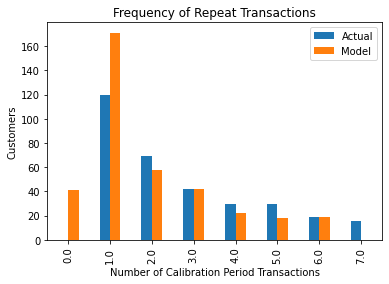

In [244]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf)

In [245]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(rfm['Frequency'],
        rfm['Monetary'])

<lifetimes.GammaGammaFitter: fitted with 772 subjects, p: 1.76, q: 2.07, v: 33271.52>

In [247]:
rfm["CLV"] = ggf.conditional_expected_average_profit(rfm["Frequency"], rfm["Monetary"])

In [248]:
rfm

,客戶名稱,Recency,Seniority,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score,predicted_purchases,alive_prob,CLV
0,一級棒輪胎有限公司,0.0,2177,1,30784.000000,1,1,3,"(1, 1, 3)",0.000014,0.000672,39883.397570
1,一誠輪胎行,0.0,1787,1,59970.000000,1,1,4,"(1, 1, 4)",0.000024,0.000915,58055.707960
2,三友輪胎行,131.0,2323,3,22933.333333,2,2,3,"(2, 2, 3)",0.000043,0.000927,28305.475687
3,三和輪業有限公司,2365.0,2372,746,289112.394102,5,5,5,"(5, 5, 5)",9.391022,0.998616,288922.266013
4,三壹汽車精品有限公司,0.0,387,1,13512.000000,1,1,2,"(1, 1, 2)",0.001166,0.009822,29129.195382
...,...,...,...,...,...,...,...,...,...,...,...,...
767,鼎鑫輪胎有限公司,67.0,76,10,109850.600000,1,3,5,"(1, 3, 5)",3.562613,0.961640,106710.359040
768,鼎鑫輪胎行,2240.0,2374,423,140618.037825,4,5,5,"(4, 5, 5)",0.000000,0.000000,140495.393615
769,龍城輪胎行,2373.0,2376,592,73598.354730,5,5,5,"(5, 5, 5)",7.448654,0.999592,73579.228665
770,龍宏龍有限公司,32.0,1888,3,24501.333333,1,2,3,"(1, 2, 3)",0.000001,0.000023,29609.942928


In [277]:
cus_sales_dict = dict(zip(df["客戶名稱"], df["業務名稱"]))

In [278]:
rfm["業務名稱"] = rfm["客戶名稱"].map(cus_sales_dict)

In [279]:
rfm["總分"] = rfm["RFM_Score"].map(lambda x: int(x[0]) + int(x[1]) + int(x[-1]))

In [280]:
rfm["等級"] = pd.qcut(rfm["總分"], [0, 0.6, 0.7, 0.8, 0.95], ["C", "B", "A", "S"])

In [281]:
rfm

,客戶名稱,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score,業務名稱,總分,等級
0,興東汽車客運股份有限公司,69,1,257040,1,1,3,"[1, 1, 3]",何書旭,5,C
1,一路發國際物流股份有限公司,13,9,683905,4,4,4,"[4, 4, 4]",何書旭,12,S
2,一進汽車貨運有限公司,24,3,304867,3,2,3,"[3, 2, 3]",洪智卿,8,C
3,七王通運股份有限公司,12,10,788647,4,4,4,"[4, 4, 4]",何書旭,12,S
4,中壢汽車客運股份有限公司,42,6,735024,2,3,4,"[2, 3, 4]",朱志昌,9,B
...,...,...,...,...,...,...,...,...,...,...,...
71,金車物流股份有限公司,39,10,1034026,2,4,4,"[2, 4, 4]",朱志昌,10,A
72,錦源通運股份有限公司,56,4,47000,2,3,1,"[2, 3, 1]",何書旭,6,C
73,隆福行股份有限公司,26,4,180698,3,3,2,"[3, 3, 2]",朱志昌,8,C
74,順翔貨櫃通運有限公司,10,19,1364054,4,4,4,"[4, 4, 4]",洪智卿,12,S


In [ ]:
# cus_code = pd.read_csv("../sales_related/ReferenceTable/category_types.csv")
cus_code = pd.read_excel("../sales_related/ReferenceTable/category_types.xlsx")

In [ ]:
cus_dict = dict(zip(cus_code["客戶代號"], cus_code["客戶"]))

In [ ]:
channel_dict = dict(zip(cus_code["客戶代號"], cus_code["小通路"]))

In [ ]:
area_dict = dict(zip(cus_code["客戶代號"], cus_code["區域"]))

In [ ]:
df.columns

In [ ]:
data = df.groupby(["實際出貨日", "訂單單號", "買方"])[["營業額"]].sum().reset_index()

In [ ]:
data["客戶名稱"] = data["買方"].map(cus_dict)

In [ ]:
data["通路"] = data["買方"].map(channel_dict)

In [ ]:
data["實際出貨日"] = pd.to_datetime(data["實際出貨日"])

In [ ]:
last_buy = data["實際出貨日"].max()

In [ ]:
rfmTable = data.groupby(["通路", "客戶名稱"]).agg({"實際出貨日": lambda x: (last_buy - x.max()).days, "訂單單號": lambda x: len(x), "營業額": lambda x: x.sum()})

In [ ]:
rfmTable["實際出貨日"] = rfmTable["實際出貨日"].astype(int)

In [ ]:
rfmTable.rename(columns={"實際出貨日": "recency", "訂單單號": "frequency", "營業額": "amount"}, inplace=True)

In [ ]:
rfmTable.head()

In [ ]:
data[data["客戶名稱"] == "一進汽車貨運有限公司"]

In [ ]:
quantiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])

In [ ]:
quantiles

In [ ]:
quantiles = quantiles.to_dict()

In [ ]:
quantiles

In [ ]:
rfmSegmentation = rfmTable

In [ ]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [ ]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['amount'].apply(FMClass, args=('amount',quantiles,))

In [ ]:
rfmSegmentation["RFMClass"] = rfmSegmentation["R_Quartile"] + rfmSegmentation["F_Quartile"] + rfmSegmentation["M_Quartile"]

In [ ]:
bins = [1, 3, 6, 9, 12]
rfmSegmentation["客戶等級"] = pd.cut(rfmSegmentation["RFMClass"], bins, labels=["C", "B", "A", "S"])

In [ ]:
rfmSegmentation

In [ ]:
rfmSegmentation[rfmSegmentation["客戶等級"] == "S"]

In [ ]:
result = rfmSegmentation.reset_index()

In [ ]:
result.to_excel(r"C:\Users\kc.hsu\Desktop\RFM_analysis.xlsx", index=False)

In [ ]:
import plotly.express as px

In [ ]:
px.scatter_3d(rfmSegmentation, x="recency", y="amount", z="frequency", color="客戶等級", height=1080, log_y=True, log_x=True)

In [ ]:
px.scatter(rfmSegmentation, x="recency", y="frequency", size="amount", color="客戶等級", log_y=True)

## 2022 June 7th更新
### Method
1. Utilize the latest 12 months' sales record to do the customer classification.
2. Only classify BSSC customers
3. Break down into area(By the responsible territory of the BSSC branch offices)

In [ ]:
df = pd.read_csv(r"D:\kc.hsu\OneDrive - Bridgestone\數據\銷售數據\2019-202205.csv")

In [ ]:
df = pd.read_pickle(r"D:\kc.hsu\OneDrive - Bridgestone\數據\銷售數據\長期銷售記錄\2017-202208.pkl")

In [ ]:
df = df[(df["實際出貨日"].between("2021-01-01", "2022-06-30")) & (df["大通路"] == "BSSC")]

In [ ]:
df["營業額"] = df["銷售數量"] * df["銷貨單價"]

In [ ]:
data = df.groupby(["實際出貨日", "訂單單號", "買方", "客戶名稱", "大通路", "小通路",  "客戶城市"])[["銷售數量", "營業額"]].sum().reset_index()

In [ ]:
data["實際出貨日"] = pd.to_datetime(data["實際出貨日"], yearfirst=True)

In [ ]:
# BSSC-FLT對照表設定
sc_flt_code = pd.read_excel("../sales_related/ReferenceTable/bssc_flt_category_types.xlsx")
cus_dict = dict(zip(sc_flt_code["客戶代號"], sc_flt_code["客戶"]))
channel_dict = dict(zip(sc_flt_code["客戶代號"], sc_flt_code["大通路"]))
area_dict = dict(zip(sc_flt_code["客戶代號"], sc_flt_code["業態"]))
city_dict = dict(zip(sc_flt_code["客戶"], sc_flt_code["區域"]))           

In [ ]:
data["客戶名稱"] = data["買方"].map(cus_dict)
data["通路"] = data["買方"].map(channel_dict)
data["區域"] = data["買方"].map(area_dict)
data["實際出貨日"] = pd.to_datetime(data["實際出貨日"])

In [ ]:
data["通路"].unique()
# BSSC-FLT條件設定
data = data[(data["通路"].isin(["BSSC-FLT"])) & (data["實際出貨日"] >= "2021-01-01")]

In [ ]:
# 條件設定
data = data[~(data["通路"].isin(["BSSC-FLT", "FLT-REP", "FLT-OE", "台灣普利司通股份有限公司", "CD", "AG"])) & (data["實際出貨日"] >= "2021-06-01")]

In [ ]:
data["區域"] = data["區域"].str.strip()
data["通路"] = data["通路"].map(lambda x: "FMC" if x == "TTC" or x == "BFP" else x)

## 客戶分類定義：
- 重要價值客戶（R高，F高，M高）
- 重要發展客戶（R高，F低，M高）
- 重要保持客戶（R低，F高，M高）
- 重要挽留客戶（R低，F低，M高）
- 一般挽留客戶（R低，F低，M低）
- 一般發展客戶（R高，F低，M低）
- 一般保持客戶（R低，F高，M低）
- 一般價值客戶（R高，F高，M低）

In [ ]:
ranking_category = ["重要價值客戶", "重要發展客戶", "重要保持客戶", "重要挽留客戶", "一般挽留客戶", "一般發展客戶", "一般保持客戶", "一般價值客戶"]
ranking_value = [(1,1,1), (1,0,1), (0,1,1), (0,0,1), (0, 0, 0), (1, 0, 0), (0, 1, 0), (1, 1, 0)]
ranking_dict = dict(zip(ranking_value, ranking_category))

In [ ]:
# 按照區域將各區域切出來個別分析
def region_devider(data):
    data_list = {}
    for i in data["客戶城市"].unique().tolist():
        globals()["area" + i] = data[data["客戶城市"] == i]
        data_list.setdefault(i + "_shape", globals()["area" + i])
    return data_list

In [ ]:
# 按照各區域通路別切出來分析
def channel_devider(data):
    data_list = {}
    for name in data.keys():
        for i in data[name]["小通路"].unique().tolist():
            globals()[name + i + "_channel"] = data[name][data[name]["小通路"] == i]
            data_list.setdefault(name + "_" + i + "_channel", globals()[name + i + "_channel"])
    return data_list


In [ ]:
# 各區數據前處理
def data_preprocessing(data):
    final_data = {}
    for i in data.keys():
        globals()[i + "_data"] = data[i].groupby([pd.Grouper(key="實際出貨日", freq="M"), "客戶名稱"]).size().reset_index()[["實際出貨日", "客戶名稱"]].drop_duplicates()
        globals()[i + "_revenue"] = data[i].groupby([pd.Grouper(key="實際出貨日", freq="M"), "客戶名稱"])[["營業額", "銷售數量"]].sum()
        globals()[i + "_final"] = globals()[i + "_data"].merge(globals()[i + "_revenue"], on=["實際出貨日", "客戶名稱"])
        globals()[i + "_final"]["小通路"] = data[i]["小通路"].unique().tolist()[0]
        final_data.setdefault(i + "_basic", globals()[i + "_final"])
    return final_data

In [ ]:
# 最後購買日期
last_buy = data["實際出貨日"].max()

In [ ]:
def score_calculation(data):
    sorted_data = {}
    for i in data.keys():
        globals()["rfmTable" + i] = data[i].groupby(["客戶名稱", "小通路"]).agg({"實際出貨日": lambda x: (last_buy - x.max()).days, "客戶名稱": lambda x: len(x), "營業額": lambda x: x.sum(), "銷售數量": lambda x: x.sum()})
        globals()["rfmTable" + i]["實際出貨日"] = globals()["rfmTable" + i]["實際出貨日"].astype(int)
        globals()["rfmTable" + i].rename(columns={"實際出貨日": "recency", "客戶名稱": "frequency", "營業額": "amount", "銷售數量": "volume"}, inplace=True)
        sorted_data.setdefault(i + "_sorted", globals()["rfmTable" + i])
    return sorted_data

In [ ]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.7]:
        return 1
    else:
        return 0
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x < d[p][0.7]:
        return 0
    else:
        return 1
    
# Arguments (x = value, p = frequency)
def FreClass(x):
    # if x < 8:
    if x < 9:
        return 0
    else: 
        return 1
        
    

In [ ]:
def quartile_calculation(data):
    sorted_data = {}
    for i in data.keys():
        globals()["quantiles" + i] = data[i].quantile(q=[0.7])
        globals()["quantiles" + i] = globals()["quantiles" + i].to_dict()
        data[i]["R_Quartile"] = data[i]["recency"].apply(RClass, args=("recency", globals()["quantiles" + i],))
        data[i]["F_Quartile"] = data[i]["frequency"].apply(FreClass)
        data[i]["M_Quartile"] = data[i]["amount"].apply(FMClass, args=("amount", globals()["quantiles" + i],))
        data[i]["Score"] = data[i][["R_Quartile", "F_Quartile", "M_Quartile"]].apply(tuple, axis=1)
        data[i]["客戶等級"] = data[i]["Score"].map(ranking_dict)
        data[i].reset_index(inplace=True)
        sorted_data.setdefault(i + "_final", data[i])
    return sorted_data       

In [ ]:
def combine_data(data):
    sorted_data = {}
    for i in data.keys():
        data[i]["客戶城市"] = i[:2]
        sorted_data.setdefault(i + "rfm_model", data[i])
    return sorted_data     
        
    

## 更換邏輯，用每一區來作為計算比重

In [ ]:
def data_preprocessing_2(data):
    final_data = {}
    for i in data.keys():
        chan_dict = dict(zip(data[i]["客戶名稱"], data[i]["通路"]))
        globals()[i + "_data"] = data[i].groupby([pd.Grouper(key="實際出貨日", freq="M"), "客戶名稱"]).size().reset_index()[["實際出貨日", "客戶名稱"]].drop_duplicates()
        globals()[i + "_revenue"] = data[i].groupby([pd.Grouper(key="實際出貨日", freq="M"), "客戶名稱"])[["營業額", "銷售數量"]].sum()
        globals()[i + "_final"] = globals()[i + "_data"].merge(globals()[i + "_revenue"], on=["實際出貨日", "客戶名稱"])
        globals()[i + "_final"]["通路"] = globals()[i + "_final"]["客戶名稱"].map(chan_dict)
        final_data.setdefault(i + "_basic", globals()[i + "_final"])
    return final_data

In [ ]:
regions = region_devider(data)
# channels = channel_devider(regions)
filtered_data = data_preprocessing_2(regions)
calculated_data = score_calculation(filtered_data)
result = quartile_calculation(calculated_data)
combined_data = combine_data(result)
final_result = pd.concat(result.values())
# final_result.to_excel(r"C:\Users\kc.hsu\Desktop\區域別_rfm_model_v2.xlsx", index=False)
# final_result.to_excel(r"C:\Users\kc.hsu\Desktop\bssc_flt_rfm_model_v2.xlsx", index=False)

In [ ]:
final_result["營業所"] = final_result["客戶名稱"].map(city_dict)
final_result.to_excel(r"C:\Users\kc.hsu\Desktop\bssc_flt_rfm_model_v2.xlsx", index=False)

## 回到原文

In [ ]:
regions = region_devider(data)
channels = channel_devider(regions)
filtered_data = data_preprocessing(channels)
calculated_data = score_calculation(filtered_data)
result = quartile_calculation(calculated_data)
combined_data = combine_data(result)
final_result = pd.concat(result.values())


In [ ]:
final_result["月平均"] = final_result["volume"] / 18

In [ ]:
import plotly.express as px
px.box(final_result["月平均"])

In [ ]:
final_result["離群值"] = final_result["月平均"].map(lambda x: "Yes" if x > 27.89 else "No")

In [ ]:
final_result["離群值"].value_counts()

In [ ]:
final_result.groupby(["離群值"])[["volume"]].sum()

In [ ]:
final_result[final_result["離群值"] == "Yes"]["月平均"].quantile([0.2, 0.5, 0.85])

In [ ]:
bins = [0, 35, 60, 125, 1000]
labels = ["No contract", "B", "A", "S"]
final_result["客戶推定等級"] = pd.cut(final_result["月平均"], bins=bins, labels=labels)

In [ ]:
signboard = pd.read_excel(r"D:\kc.hsu\OneDrive - Bridgestone\行銷推廣\掛牌店\2022年FMC店數.xlsx", sheet_name="工作表1")

In [ ]:
signboard.columns = ['編號', '營業所', '客戶代號', '通路', '客戶簡稱', '月均需求(BS,MI,MA)', '月均需求(所有品牌)',
       'BS signboard', 'BS招牌安裝日', '是否有意願裝BS招牌', 'MI合約到期日', '是否簽附加合約', '簽約等級',
       '2021年銷售量', '2022年銷售量', 'Growth rate', '是否保留']

In [ ]:
signboard_dict = dict(zip(signboard["客戶簡稱"], signboard["BS signboard"]))

In [ ]:
final_result["FMC"] = final_result["客戶名稱"].map(signboard_dict).fillna("No")

In [ ]:
final_result["談約排序"] = final_result.apply(lambda x: "最優先" if x["客戶推定等級"] != "No contract" and x["FMC"] != "No" else "優先" if x["客戶推定等級"] != "No contract" and x["FMC"] == "No" else "優先確認意向" if x["客戶推定等級"] == "No contract" and x["FMC"] != "No" else "一般", axis=1)

In [ ]:
final_result.to_excel(r"C:\Users\kc.hsu\Desktop\20221206_rfm_model.xlsx", index=False)

## 2019年~2022年4月銷售實績RFM模型建立
- 使用K-Means演算法分群
- 每個月的頻率只用有無下單來累計，因為有的客戶每月下很多小單，但大客戶一個月只下一張單，這樣Frequency的分數會被影響到，需排除這個問題

### 使用手動分群4群和使用K-means來找出最適合的群組

In [ ]:
df = pd.read_excel(r"D:\kc.hsu\OneDrive - Bridgestone\數據\銷售數據\2019-202204.xlsx")

In [ ]:
df["營業額"] = df["銷售數量"] * df["銷貨單價"]

In [ ]:
data = df.groupby(["實際出貨日", "訂單單號", "買方"])[["銷售數量", "營業額"]].sum().reset_index()

In [ ]:
data["客戶名稱"] = data["買方"].map(cus_dict)
data["通路"] = data["買方"].map(channel_dict)
data["實際出貨日"] = pd.to_datetime(data["實際出貨日"])

In [ ]:
data = data[data["通路"] == "BSSC"]

In [ ]:
test_1 = data.groupby([pd.Grouper(key="實際出貨日", freq="M"), "客戶名稱"]).size().reset_index()[["實際出貨日", "客戶名稱"]].drop_duplicates()

In [ ]:
test_1

In [ ]:
test_2 = data.groupby([pd.Grouper(key="實際出貨日", freq="M"), "客戶名稱"])[["營業額", "銷售數量"]].sum()

In [ ]:
test_3 = test_1.merge(test_2, on=["實際出貨日", "客戶名稱"])

In [ ]:
last_buy = data["實際出貨日"].max()

In [ ]:
rfmTable = test_3.groupby(["客戶名稱"]).agg({"實際出貨日": lambda x: (last_buy - x.max()).days, "客戶名稱": lambda x: len(x), "營業額": lambda x: x.sum(), "銷售數量": lambda x: x.sum()})

In [ ]:
# rfmTable = data.groupby(["通路", "客戶名稱"]).agg({"實際出貨日": lambda x: (last_buy - x.max()).days, "訂單單號": lambda x: len(x), "營業額": lambda x: x.sum(), "銷售數量": lambda x: x.sum()})

In [ ]:
# rfmTable.rename(columns={"實際出貨日": "recency", "訂單單號": "frequency", "營業額": "amount", "銷售數量": "volume"}, inplace=True)

In [ ]:
rfmTable["實際出貨日"] = rfmTable["實際出貨日"].astype(int)

In [ ]:
rfmTable.rename(columns={"實際出貨日": "recency", "客戶名稱": "frequency", "營業額": "amount", "銷售數量": "volume"}, inplace=True)

### 數據前處理後為四個欄位
1. Recency(代表客戶最後一次購買距離數據裡面最後面的日期4/30)
2. Frequncy(代表客戶購買頻率，扣除掉前面的說明，就是客戶40個月的區間有幾個月有下過訂單)
3. Amount(代表客戶在數據區間中累計的營業額貢獻)
4. Volume(代表客戶在數據區間中累計的條數）

In [ ]:
rfmTable

In [ ]:
quantiles = rfmTable.quantile(q=[0.2, 0.4, 0.6, 0.8])
quantiles = quantiles.to_dict()

### 按照每個特徵值的20%，40%，60%，80%的值來做區間分佈

In [ ]:
quantiles

In [ ]:
rfmSegmentation = rfmTable.copy()

In [ ]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <=d[p][0.8]:
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]:
        return 4
    else:
        return 5

In [ ]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['amount'].apply(FMClass, args=('amount',quantiles,))
rfmSegmentation["V_Quartile"] = rfmSegmentation["volume"].apply(FMClass, args=("volume", quantiles,))

In [ ]:
rfmSegmentation

In [ ]:
rfmSegmentation["RFMClass"] = rfmSegmentation["R_Quartile"] + rfmSegmentation["F_Quartile"] + rfmSegmentation["M_Quartile"] + rfmSegmentation["V_Quartile"]

In [ ]:
bins = [3, 8, 12, 16, 20]
rfmSegmentation["客戶等級"] = pd.cut(rfmSegmentation["RFMClass"], bins, labels=["C", "B", "A", "S"])

In [ ]:
### 將客戶手動分為4個群組

In [ ]:
rfmSegmentation

## K-means分群

In [ ]:
rfmSegmentation_k = rfmSegmentation.copy().reset_index()

In [ ]:
rfmSegmentation_k

In [ ]:
sc_customers = rfmSegmentation_k

In [ ]:
sc_customers = sc_customers[["客戶名稱", "R_Quartile", "F_Quartile", "M_Quartile", "V_Quartile"]]

In [ ]:
sc_customers

In [7]:
from sklearn.cluster import KMeans

In [ ]:
test = sc_customers.drop(sc_customers.columns[0], axis=1)

In [ ]:
wcss = []
for i in range(1,30):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(test)
    wcss.append(kmeans.inertia_)

## 損失函數圖

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.plot(range(1,30), wcss, marker='o')
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

## 以損失函數來看分8群左右就已經基本可以反應了

In [ ]:
kmeans = KMeans(n_clusters=8, init='k-means++', random_state=0)
sc_customers_2=sc_customers.drop(sc_customers.columns[0], axis=1)
sc_customers['clusters'] = kmeans.fit_predict(sc_customers_2)
sc_customers.tail(10)

In [ ]:
sc_customers_2.head(10)

## 檢查最佳的是在第幾群，可以看出最佳在第二群

In [30]:
round(pd.DataFrame(kmeans.cluster_centers_),2)

AttributeError: 'KMeans' object has no attribute 'cluster_centers_'

In [ ]:
kmeans_result = round(pd.DataFrame(kmeans.cluster_centers_),2)

In [ ]:
kmeans_result["score"] = kmeans_result.sum(axis=1)

In [ ]:
kmeans_result

In [ ]:
kmeans_rank_dict = {2: "VIP", 4: "S", 6: "A", 0: "B", 7: "C", 3: "D", 5: "E", 1: "F"}

In [ ]:
sc_customers["客戶等級"] = sc_customers["clusters"].map(kmeans_rank_dict)

In [ ]:
cluster_result = sc_customers

In [ ]:
cluster_result

In [ ]:
rfmSegmentation_k.columns

In [ ]:
final_result = sc_customers.merge(rfmSegmentation_k, on=['客戶名稱', 'R_Quartile', 'F_Quartile', 'M_Quartile', 'V_Quartile'])

In [ ]:
final_result.to_excel(r"C:\Users\kc.hsu\Desktop\kmeans_rfm_model.xlsx", index=False)

In [ ]:
import plotly.express as px
import plotly
plotly.offline.init_notebook_mode()

In [ ]:
k_means_plot = px.scatter_3d(final_result, x="recency", y="amount", z="frequency", color="客戶等級_x", log_y=True, log_x=True, height=1080, title="K-means分群", hover_data=["客戶名稱"])
k_means_plot.show()

In [ ]:
manual_cluster_plot = px.scatter_3d(final_result, x="recency", y="amount", z="frequency", color="客戶等級_y", log_y=True, log_x=True, height=1080, title="人工分群")
manual_cluster_plot.show()

### 20230613 Kmeans實作

In [55]:
df = pd.read_excel(r"D:\kc.hsu\OneDrive - Bridgestone\行銷推廣\客戶分群\2023年上半年\20230605_RFM.xlsx", None)

In [56]:
result = df["Sheet1"]

In [57]:
test = result[["Recency", "Frequency", "Monetary"]]

In [46]:

final = KMeans(init="k-means++", n_clusters=4, max_iter=10000, n_init=100).fit(test)

In [58]:
wcss = []
for i in range(1,30):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0, max_iter=10000, n_init=100)
    kmeans.fit(test)
    wcss.append(kmeans.inertia_)

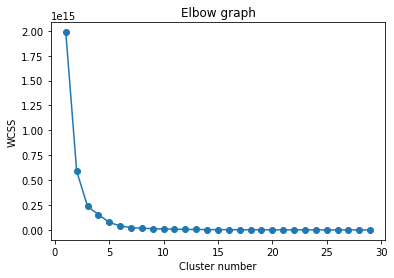

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.plot(range(1,30), wcss, marker='o')
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

In [60]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0, max_iter=10000, n_init=100)
test['clusters'] = kmeans.fit_predict(test)
test.tail(10)

C:\Users\kc.hsu\AppData\Local\Temp\ipykernel_17248\2339854965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['clusters'] = kmeans.fit_predict(test)


,Recency,Frequency,Monetary,clusters
326,143,1,29336,0
327,143,1,78900,0
328,145,1,26636,0
329,147,3,72498,0
330,147,2,23642,0
331,149,1,7527,0
332,149,1,29336,0
333,151,1,14860,0
334,152,1,7430,0
335,153,1,13896,0


In [62]:
kmeans.predict([[2, 50, 5000000]])

c:\Users\kc.hsu\Python workspace\python_env\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


array([3])

In [63]:
kmeans.cluster_centers_

array([[5.11423221e+01, 3.26217228e+00, 2.08284719e+05],
       [5.66666667e+00, 6.20000000e+01, 1.68914780e+07],
       [2.06538462e+01, 1.57884615e+01, 1.96957040e+06],
       [8.07692308e+00, 3.92307692e+01, 5.40898562e+06],
       [5.00000000e+00, 1.49000000e+02, 2.71951360e+07]])

In [64]:
kmeans.labels_

array([4, 1, 3, 3, 3, 1, 2, 3, 3, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 3, 3,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 3, 2, 2, 0, 3, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 3, 0, 2, 0, 0, 0, 0,
       2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 3, 2, 2, 3, 0, 0, 0, 0, 0, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2,
       2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [65]:
round(pd.DataFrame(kmeans.cluster_centers_), 0)

,0,1,2
0,51.0,3.0,208285.0
1,6.0,62.0,16891478.0
2,21.0,16.0,1969570.0
3,8.0,39.0,5408986.0
4,5.0,149.0,27195136.0
